In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import os, time,json
import tmdbsimple as tmdb 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tqdm.notebook import tqdm_notebook

In [34]:
basics_url = 'https://datasets.imdbws.com/title.basics.tsv.gz'
aka_url ='https://datasets.imdbws.com/title.akas.tsv.gz'
rating_url='https://datasets.imdbws.com/title.ratings.tsv.gz'

In [ ]:
basics = pd.read_csv(basics_url,sep='\t', low_memory=False)
akas = pd.read_csv(aka_url,sep='\t', low_memory=False)
ratings = pd.read_csv(rating_url,sep='\t', low_memory=False)

In [ ]:
basics=basics.replace({'\\N':np.nan}) #replace with usable null format
akas=akas.replace({'\\N':np.nan})
ratings=ratings.replace({'\\N':np.nan})


In [ ]:
basics.head()

In [ ]:
basics=basics.dropna(subset=['runtimeMinutes']) #drop nulls in runtime

In [ ]:
basics=basics.dropna(subset=['genres']) #drop nulls in genres

In [ ]:
documentary = basics['genres'].str.contains('documentary',case=False) #drop documentaries
basics = basics[~documentary]

In [ ]:
basics=basics.loc[basics['titleType'] == 'movie'] #limit output to only movies

In [ ]:
basics['startYear']=basics['startYear'].replace({np.nan:0}) #disregard null values
basics['startYear']=basics['startYear'].astype(object).astype(int) #convert object to int
basics=basics.loc[basics['startYear'].between(2000,2022)] 

In [ ]:
akas.head()

In [ ]:
akas=akas.loc[akas['region'] == 'US'] #keep only US titles

In [ ]:
akas.head()

In [ ]:
# Filter the basics table down to only include the US by using the filter akas dataframe
keepers =basics['tconst'].isin(akas['titleId'])
keepers



In [ ]:
basics = basics[keepers]
basics



In [ ]:
keepers_rating =ratings['tconst'].isin(akas['titleId'])
ratings = ratings[keepers_rating]


In [ ]:
# example making new folder with os
os.makedirs('Data/',exist_ok=True) 
# Confirm folder created
os.listdir("Data/")

In [ ]:
basics.to_csv("Data/title_basics_resubmit.csv.gz",compression='gzip',index=False)


In [2]:
# Open saved file and preview again
basics = pd.read_csv("Data/title_basics_resubmit.csv.gz", low_memory = False)
basics.head()



,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0094859,movie,Chief Zabu,Chief Zabu,0,2016,NaN,74,Comedy


In [3]:
#akas.to_csv("Data/akas_resubmit.csv.gz",compression='gzip',index=False)




In [4]:
akas = pd.read_csv("Data/akas_resubmit.csv.gz", low_memory = False)
akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [5]:
#ratings.to_csv("Data/ratings_resubmit.csv.gz",compression='gzip',index=False)




In [6]:
# Open saved file and preview again
ratings = pd.read_csv("Data/ratings_resubmit.csv.gz", low_memory = False)
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1905
1,tt0000002,5.8,256
2,tt0000005,6.2,2518
3,tt0000006,5.1,173
4,tt0000007,5.4,783


In [7]:
with open('/Users/svaze/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()



dict_keys(['api-key'])

In [8]:
tmdb.API_KEY =  login['api-key']



In [9]:
def get_movie_with_rating(movie_id):
# Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
# save the .info .releases dictionaries
    movie_info = movie.info()
    releases = movie.releases()
# Loop through countries in releases
    for c in releases['countries']:
    # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
        ## save a "certification" key in the info dict with the certification
           movie_info['certification'] = c['certification']
    return movie_info    


In [10]:
def write_json(new_data, filename): 
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""    
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)


In [11]:
FOLDER = "Data1/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)



[]

## Part 4

In [12]:
YEARS_TO_GET = [2012,2013,2014,2015,2016]



In [14]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET,desc='YEARS',position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    basics = pd.read_csv("Data/title_basics_resubmit.csv.gz", low_memory = False)        
    #Saving new year as the current df
    df = basics.loc[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    #Get index and movie id from list
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

    
    for movie_id_year in tqdm_notebook(movie_ids_to_get, desc=f'Movies from {YEAR}', position=1, leave=True):
        try:
            temp = get_movie_with_rating(movie_id_year)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        # If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            continue
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)







YEARS:   0%|          | 0/5 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4432 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4640 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4779 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/4930 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5140 [00:00<?, ?it/s]

In [19]:
import glob
q = "Data1/final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
chunked_files[:5]

['Data1\\final_tmdb_data_2012.csv.gz',
 'Data1\\final_tmdb_data_2013.csv.gz',
 'Data1\\final_tmdb_data_2014.csv.gz',
 'Data1\\final_tmdb_data_2015.csv.gz',
 'Data1\\final_tmdb_data_2016.csv.gz']

In [20]:
df_combined = pd.concat([pd.read_csv(file, index_col=0) for file in chunked_files])

In [21]:
final_fname ='Data/final_tmdb_data_12_16.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)

In [61]:
pd.set_option('display.max_columns', None)
df_combined = pd.read_csv(final_fname)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/t7zb6CnRQwhzQSq0apR4ESFYiWN.jpg,NaN,65000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...",http://www.thresholdanimationstudios.com/video...,116977.0,en,Foodfight!,The evil Brand X joins a supermarket that beco...,8.319,/to9ggXVyhNTCICHcHMCtFtANd8P.jpg,"[{'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-06-15,73706.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Foodfight!,0.0,1.864,107.0,PG-13
2,0.0,/pKOHinAVIkyqLliMaTHCSL1T4zU.jpg,NaN,4000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,112074.0,pl,Life's a Beach,Darren gets stood up on the day of his wedding...,0.769,/v4RlCWc0ixi2ON6HWcZftO7U2P2.jpg,"[{'id': 85165, 'logo_path': None, 'name': 'Mir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-01-01,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Life's a Beach,0.0,2.500,5.0,R
3,0.0,/cj2isIuskSePAwpb2D6yUBZrhkJ.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,136884.0,en,Dark Blood,Filmed in 1993 but never completed due to Rive...,2.174,/oAfT3B8efpfuQ65dqy7We3GvlH.jpg,"[{'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqm...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2012-09-27,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Dark Blood,0.0,6.100,17.0,NaN
4,0.0,/5dUOTVeNPU2CmEfFniQ8TE6HChG.jpg,NaN,25000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",http://www.ontheroad-themovie.com/?lang=en,83770.0,en,On the Road,Dean and Sal are the portrait of the Beat Gene...,14.263,/k7LQteD02p3VHixbS6NXHkFdFwT.jpg,"[{'id': 70, 'logo_path': '/ueaENQkPcy8rlr5fGZV...","[{'iso_3166_1': 'BR', 'name': 'Brazil'}, {'iso...",2012-05-22,8784318.0,137.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The best teacher is experience.,On the Road,0.0,5.614,730.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17976,0.0,/bASfXeZbPcizNUGFWbPpzeMHgq9.jpg,NaN,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,594885.0,zh,"错了性别, 不错爱",Two roommates living in an all-girl dormitory....,1.778,/kLzzvOP29SHrBa7ryUuwLsLUqeD.jpg,[],[],2016-02-25,0.0,60.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,Girls Love,0.0,5.000,4.0,NaN
17977,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n...",NaN,398655.0,zh,Strange Battle,Strange Battle 2016 is based on a strange inci...,0.600,/4yZOgWoN58GPbx2toC2rC5vgy3g.jpg,[],"[{'iso_3166_1': 'CN', 'name': 'China'}]",2016-01-22,0.0,90.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,Strange Battle,0.0,0.000,0.0,NaN
17978,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,914301.0,zh,Hi高考君,NaN,0.600,/aMhLd7chW4nqcB4hktUpNf1jNXH.jpg,[],"[{'iso_3166_1': 'CN', 'name': 'China'}]",2016-08-19,0.0,0.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,NaN,Hi高考君,0.0,0.000,0.0,NaN
17979,0.0,/f2HAgJuweEdeQJi4Mzshu6WxRPD.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,475943.0,en,Couple of Days,"Three couples, each in different phases of rom...",1.758,/1xbOalfd97D8wwy7G5oflJOOXD1.jpg,[],"[{'iso_3166_1': 'NG', 'name': 'Nigeria'}]",2016-02-05,0.0,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Couple of Days,0.0,4.000,1.0,NaN


### Question 1: Does MPAA Rating affect Movie Revenue?

Null Hypothesis: There is no significant difference across movies with different ratings regarding their revenue totals.

Alt Hypothesis: MPAA rating does statistically significantly impact the revenue a movie makes.

Alpha = 0.05

ANOVA Test

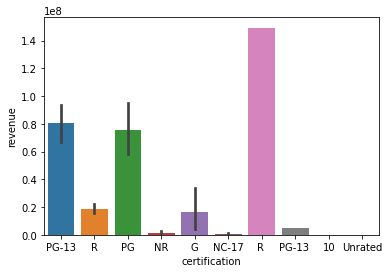

In [62]:
sns.barplot(data=df_combined, x='certification',y='revenue');

In [63]:
df_combined=df_combined.dropna(subset=['certification','revenue'])

In [64]:
groups = {}
## Loop through all unique categories
for i in df_combined['certification'].unique():
    ## Get series for group and rename
    data = df_combined.loc[df_combined['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'R', 'PG', 'NR', 'G', 'NC-17', 'R ', 'PG-13 ', '10', 'Unrated'])

Samples are large enough to ignore normalcy

In [65]:
stats.levene(*groups.values()) #check for equal variance

LeveneResult(statistic=33.4196666008402, pvalue=2.2413073520789058e-57)

In [66]:
result = stats.f_oneway(*groups.values())
result

F_onewayResult(statistic=33.497154522222374, pvalue=1.6304910375684943e-57)

In [67]:
## save the values as revenue and the labels to the certification
values = df_combined['revenue']
labels = df_combined['certification']

In [68]:
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
10,G,16434040.1983,1.0,-367302293.943,400170374.3397,False
10,NC-17,430953.1607,1.0,-385126503.2987,385988409.6201,False
10,NR,1421372.1897,1.0,-380897313.3083,383740057.6878,False
10,PG,75493770.8045,0.9998,-307139315.9257,458126857.5346,False
10,PG-13,80360041.935,0.9997,-302010749.1557,462730833.0258,False
10,PG-13,4825184.0,1.0,-535631248.3438,545281616.3438,False
10,R,18812844.9593,1.0,-363469173.6029,401094863.5214,False
10,R,149295601.0,0.9972,-391160831.3438,689752033.3438,False
10,Unrated,0.0,1.0,-427268325.5738,427268325.5738,False
G,NC-17,-16003087.0376,0.9983,-77768539.4354,45762365.3601,False


Since our p value is less than the alpha, we reject the NH and accept the AH, and say that MPAA rating does affect the revenue totals of a movie.

p-value = 1.63
R rated movies appear to return the highest revenue overall.

### Question 2: Do movies longer than 96 minutes earn more than those shorter?

NH: All movies regardless of runtime earn similar final revenue totals.

AH: Runtime does statistically affect the earning potential of a movie.

Alpha = 0.05

Independent T-Test

In [69]:
df_combined['runtime'].mean() #find mean as comparison point

96.2400561534862

In [73]:
# Filtering out movies above and below mean
df_combined=df_combined.dropna(subset=['runtime','revenue'])
long = df_combined.loc[df_combined['runtime'] > 96].copy()
short = df_combined.loc[df_combined['runtime'] <= 96].copy()

In [74]:
long = long['revenue'] #target feature: revenue by runtime
short = short['revenue']

In [77]:
zscores_short= stats.zscore(short) #short movie outliers
outliers_short = abs(zscores_short)>3
np.sum(outliers_short)

32

In [78]:
zscores_long= stats.zscore(long) #short movie outliers
outliers_long = abs(zscores_long)>3
np.sum(outliers_long)

50

In [79]:
long = long[(np.abs(stats.zscore(long)) <= 3)]         #exclude outliers
short = short[(np.abs(stats.zscore(short)) <= 3)]

In [81]:
normal_long = stats.normaltest(long) #check for normal distribution in discount group
normal_long


NormaltestResult(statistic=1230.579550254418, pvalue=6.068004452147406e-268)

In [82]:
normal_short = stats.normaltest(short) #check for normal distribution in discount group
normal_short


NormaltestResult(statistic=2757.559719756269, pvalue=0.0)

Sample sizes are large enough for normal test to be ignored

In [86]:
result = stats.levene(long, short)
result

LeveneResult(statistic=345.07736071950194, pvalue=4.3885833526026036e-74)

In [87]:
# Independent t-test with equal_var set to False
result_ttest = stats.ttest_ind(long, short, equal_var = False)
result_ttest

Ttest_indResult(statistic=16.398007809768263, pvalue=1.1577299601419766e-56)

We reject the NH and accept the AH, that runtime, does affect the revenue totals of movies, and we can also conclude that movies longer than the mean tend to earn more than those shorter

### Question 3: Does a MPAA rating affect the number of votes a movie receives?

NH: Voting is independent of movie rating, and makes no impact.

AH: Movie rating plays a role in the voting behavior of the public. 

alpha = 0.05

ANOVA




In [88]:
groups = {}
## Loop through all unique categories
for i in df_combined['certification'].unique():
    ## Get series for group and rename
    data = df_combined.loc[df_combined['certification']==i,'vote_count'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'R', 'PG', 'NR', 'G', 'NC-17', 'R ', 'PG-13 ', '10', 'Unrated'])

In [89]:
stats.levene(*groups.values()) #check for equal variance

LeveneResult(statistic=32.69570055042122, pvalue=4.387235928307552e-56)

In [90]:
result = stats.f_oneway(*groups.values())
result

F_onewayResult(statistic=33.47841262513405, pvalue=1.7609186821363564e-57)

In [91]:
## save the values as kg_lost and the labels to the Diet
values = df_combined['vote_count']
labels = df_combined['certification']

In [92]:
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
10,G,159.9835,1.0,-7305.2883,7625.2552,False
10,NC-17,125.6607,1.0,-7375.0395,7626.3609,False
10,NR,50.1508,1.0,-7387.5418,7487.8434,False
10,PG,1012.4851,1.0,-6431.3239,8456.2941,False
10,PG-13,1777.6542,0.9991,-5661.0521,9216.3604,False
10,PG-13,126.0,1.0,-10388.1311,10640.1311,False
10,R,890.9599,1.0,-6546.0194,8327.9392,False
10,R,3560.0,0.9874,-6954.1311,14074.1311,False
10,Unrated,-25.5,1.0,-8337.6505,8286.6505,False
G,NC-17,-34.3228,1.0,-1235.9183,1167.2728,False


We reject the NH and accept the NH, so vote count is impacted by the MPAA rating of a movie.